# Modelling - Billboard Hot 100 & Spotify Track Data

## 1.0 Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import Ridge, Lasso, LogisticRegression

In [2]:
#import data
data = pd.read_csv('../data/processed/prepro-merged', index_col=0)

data.head()

,BB_Title,BB_Artist,PeakPos,danceability,energy,key,loudness,mode,speechiness,acousticness,...,tm_246,tm_247,tm_248,tm_249,tm_250,tm_251,tm_252,tm_253,tm_254,tm_255
0,Stay,The Kid LAROI & Justin Bieber,1,0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bad Habits,Ed Sheeran,2,0.808,0.897,11.0,-3.712,0.0,0.0348,0.0469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Good 4 U,Olivia Rodrigo,1,0.563,0.664,9.0,-5.044,1.0,0.1540,0.3350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Rumors,Lizzo Featuring Cardi B,4,0.827,0.731,4.0,-5.524,0.0,0.0880,0.1300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Kiss Me More,Doja Cat Featuring SZA,3,0.762,0.701,8.0,-3.541,1.0,0.0286,0.2350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data.shape

(4609, 272)

## 2.0 Picking the Classification Model

During pre-processing and training in step 4, regression models were tested and the results indicated that estimating the Peak Position of a song would garner unreliable results. For that reason, the intention has pivoted to a model that classifies songs as having an attribute set likely to peak in the top 10 of the Billboard 100.

In [4]:
#this variable changes the PeakPos value to a 1 or 0 if the song hits top 10 or not, respectively
data['y'] = data.PeakPos.apply(lambda x: 1 if x <= 10 else 0)

data.y.value_counts()

0    4061
1     548
Name: y, dtype: int64

In [5]:
features = data.drop(columns=['PeakPos','BB_Title', 'BB_Artist','y'])

X = features.values
y = data.y.values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
#this will be how the different models are scored
def scoring(model, X_test=X_test, y_test=y_test, X_train=X_train, y_train=y_train):
    a_score = accuracy_score(model.predict(X_test), y_test)
    cv_train = cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc')
    cv_test = cross_val_score(model,X_test,y_test,cv=5,scoring='roc_auc')
    
    print("Accuracy Score: {0}".format(a_score))
    print(confusion_matrix(y_test, model.predict(X_test)))
    print("Mean Test Data CV: {0}".format(cv_train.mean()))
    print("Mean Training Data CV: {0}".format(cv_test.mean()))
    
    return a_score, cv_train.mean(), cv_test.mean()

In [9]:
#this will create the roc_graph
def ROC_graph(model, name, X_test=X_test, y_test=y_test):
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{0} (area = %0.2f)'.format(name) % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### 2.1 Logistic Regression

In [10]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [11]:
#the grid of parameters to search over
C = [0.001, 0.1, 1, 10, 100]

scores = []
max_score = 0
max_c = 0

for val in C:
    lr = LogisticRegression(C=val, random_state=42)
    score = cv_score(lr, X_train, y_train)
    if score > max_score:
        max_c = val
        max_score = score
    
    scores.append(score)

max_c, max_score, scores

(0.1,
 0.8781817745458037,
 [0.8778707370341037,
  0.8781817745458037,
  0.8775616195070439,
  0.8775620995032039,
  0.8775620995032039])

In [12]:
#use the above best C, 0.1
lr = LogisticRegression(C=0.1, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42)

In [13]:
lr_accuracy_score, lr_cv_train, lr_cv_test = scoring(lr)

Accuracy Score: 0.8879248011569053
[[1226    3]
 [ 152    2]]
Mean Test Data CV: 0.7399930079339462
Mean Training Data CV: 0.6602995837726645


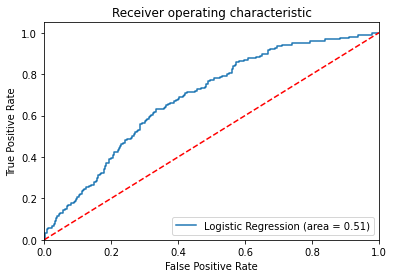

In [14]:
ROC_graph(lr, 'Logistic Regression')

### 2.2 K-Nearest Neighbor

In [15]:
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.8781774545803633
Best Parameters: {'n_neighbors': 48}


In [16]:
knn = KNeighborsClassifier(n_neighbors=48)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=48)

In [17]:
knn_accuracy_score, knn_cv_train, knn_cv_test = scoring(knn)

Accuracy Score: 0.8893709327548807
[[1229    0]
 [ 153    1]]
Mean Test Data CV: 0.7105581540508707
Mean Training Data CV: 0.6354820958018664


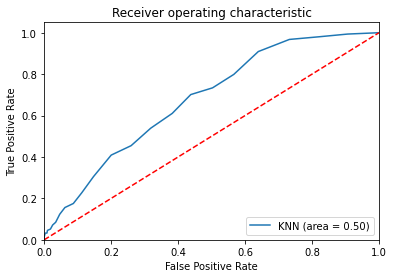

In [18]:
ROC_graph(knn, 'KNN')

### 2.3 Random Forest Model

In [19]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train,y_train)

rf_accuracy_score, rf_cv_train, rf_cv_test = scoring(rf)

Accuracy Score: 0.888647866955893
[[1225    4]
 [ 150    4]]
Mean Test Data CV: 0.6981677849524359
Mean Training Data CV: 0.6584120650620595


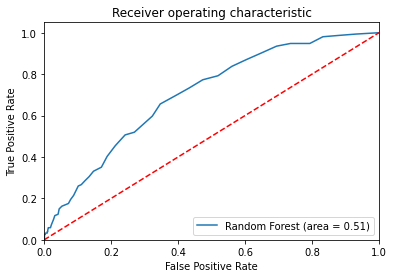

In [20]:
ROC_graph(rf, 'Random Forest')

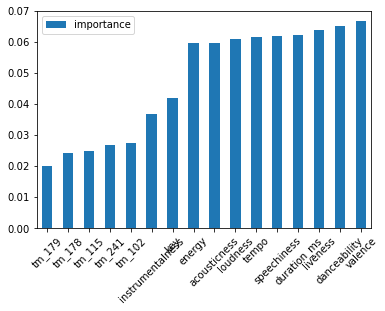

In [21]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(features.columns, rf.feature_importances_):
    if importance >= 0.02:
        feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})

importances.sort_values(by='importance').plot(kind='bar', rot=45)
plt.show()

#### 2.3.1 Random Forest Hyperparameter Tuning

In [22]:
#reference material: 
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [23]:
#random search will be done first, then grid search to focus the hyperparameter tuning
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

#values for this were referenced at the link
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 500, num=10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [24]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 64, 118, 173, 227,
                                                         282, 336, 391, 445,
                                                         500]},
                   random_state=42, verbose=2)

In [25]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [26]:
#score this model based on best estimator
best_random = rf_random.best_estimator_
rfbr_accuracy_score, rfbr_cv_train, rfbr_cv_test = scoring(best_random)

Accuracy Score: 0.888647866955893
[[1228    1]
 [ 153    1]]
Mean Test Data CV: 0.7248226785781517
Mean Training Data CV: 0.6677855563940761


In [27]:
#adjust params best on randomCV results
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [500, 750, 1000]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [28]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 10, 15, 20],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [500, 750, 1000]},
             verbose=2)

In [29]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 750}

In [30]:
best_grid = grid_search.best_estimator_
rfbg_accuracy_score, rfbg_cv_train, rfbg_cv_test = scoring(best_grid)

Accuracy Score: 0.888647866955893
[[1228    1]
 [ 153    1]]
Mean Test Data CV: 0.7250577198821099
Mean Training Data CV: 0.6703967094312155


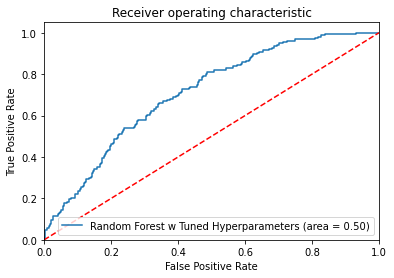

In [31]:
ROC_graph(best_grid, 'Random Forest w Tuned Hyperparameters')

## 3.0 Conclusion

In [32]:
x_label = ['LogReg', 'KNN', 'RF', 'RF - Tuned']

accuracy_scores = [lr_accuracy_score, knn_accuracy_score, rf_accuracy_score, rfbg_accuracy_score]
cv_train = [lr_cv_train, knn_cv_train, rf_cv_train, rfbg_cv_train]
cv_test = [lr_cv_test, knn_cv_test, rf_cv_test, rfbg_cv_test]

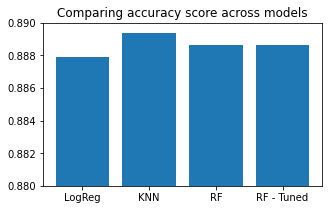

In [33]:
plt.subplots(figsize=(5, 3))
plt.ylim([0.88, 0.89])
plt.bar(x_label, accuracy_scores)
plt.title("Comparing accuracy score across models")
plt.show()

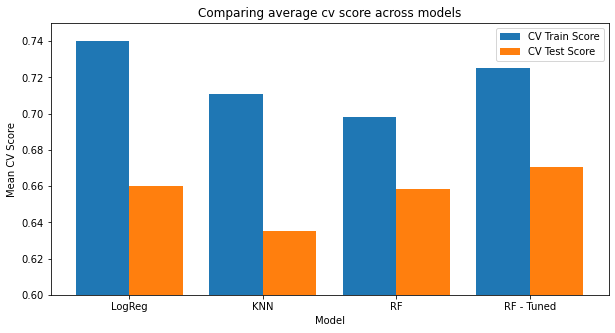

In [34]:
x_axis = np.arange(len(x_label))

plt.subplots(figsize=(10, 5))
plt.ylim([0.6, 0.75])
plt.bar(x_axis-0.2, cv_train, 0.4, label='CV Train Score')
plt.bar(x_axis+0.2, cv_test, 0.4, label='CV Test Score')

plt.xlabel("Model")
plt.xticks(x_axis, x_label)
plt.ylabel("Mean CV Score")
plt.title("Comparing average cv score across models")
plt.legend()

plt.show()

KNN had the best accuracy score but Random Forest is a better option for its CV scores and the benefit of available feature importances that could be used in future exploration.